In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ----------------------
# 1. Load dataset
# ----------------------
mush_train = pd.read_csv('mush_train.csv')

y = mush_train['poisonous']
X = mush_train.drop(columns=['poisonous']).set_index('Id')

categorical_cols = ['cap.shape', 'cap.color', 'bruises',
                    'stalk.color.above.ring', 'stalk.color.below.ring',
                    'population']

# ----------------------
# 2. Feature engineering
# ----------------------
danger_colors = ['r', 'o', 'y']
safe_colors = ['n', 'w', 'c', 'b']


X['num_danger_colors'] = X[['cap.color', 'stalk.color.above.ring', 'stalk.color.below.ring']].isin(danger_colors).sum(axis=1)
X['num_safe_colors'] = X[['cap.color', 'stalk.color.above.ring', 'stalk.color.below.ring']].isin(safe_colors).sum(axis=1)
X['cap_stalk_color_combo'] = X['cap.color'] + "_" + X['stalk.color.above.ring'] + "_" + X['stalk.color.below.ring']
X['shape_ring_bruises'] = X['cap.shape'] + "_" + X['stalk.color.above.ring'] + "_" + X['bruises'].astype(str)
X['pop_bruises_combo'] = X['population'] + "_" + X['bruises'].astype(str)
X['pop_capshape_combo'] = X['population'] + "_" + X['cap.shape']
X['has_red_and_conical'] = ((X['cap.color'] == 'r') & (X['cap.shape'] == 'c')).astype(int)
X['has_yellow_and_flat'] = ((X['cap.color'] == 'y') & (X['cap.shape'] == 'f')).astype(int)

# ----------------------
# 3. Train-test split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ----------------------
# 4. Preprocessing
# ----------------------
# Categorical + new combo features
all_categorical = categorical_cols + [
    'cap_stalk_color_combo', 'shape_ring_bruises',
    'pop_bruises_combo', 'pop_capshape_combo'
]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), all_categorical)
], remainder='passthrough')  # Keep numeric engineered features like counts and flags

# ----------------------
# 5. Pipeline & Hyperparameter search
# ----------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [200, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',  # focus on catching all poisonous mushrooms
    cv=5,
    n_jobs=-1,
    verbose=2
)

# ----------------------
# 6. Fit model
# ----------------------
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print('Best parameters:', grid_search.best_params_)
print('Best recall (CV):', grid_search.best_score_)

# ----------------------
# 7. Predict & tune threshold
# ----------------------
probs = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs)
indices_recall_1 = np.where(recall == 1)[0]

if len(indices_recall_1) > 0:
    best_index = indices_recall_1[np.argmax(precision[indices_recall_1])]
    best_threshold = thresholds[best_index - 1] if best_index > 0 else 0
    best_precision = precision[best_index]
else:
    best_threshold = 0.5  # fallback
    best_precision = precision[0]

print(f'Tuned threshold: {best_threshold:.4f} for zero poisonous false negatives.')

# ----------------------
# 8. Evaluate safe edible mushrooms
# ----------------------
y_pred = (probs >= best_threshold).astype(int)
true_positives_edible = ((y_test == 0) & (y_pred == 0)).sum()
total_edible = (y_test == 0).sum()

print(f'Safe edible mushrooms: {true_positives_edible}/{total_edible} ({(true_positives_edible/total_edible)*100:.2f}%)')


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier__max_depth=10, classifier__max_featu

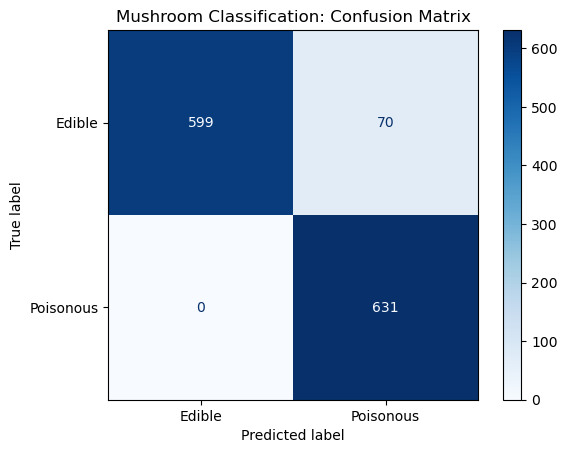

In [ ]:
# Compute predictions using the trained pipeline
y_pred = (probs >= best_threshold).astype(int)

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible', 'Poisonous'])
disp.plot(cmap='Blues')
plt.title('Mushroom Classification: Confusion Matrix')
plt.show()
